# 3相電流の変換とその誤差の影響

[モーター駆動電流ループにおける非理想的効果の影響を理解するためのシステムアプローチ](https://www.analog.com/en/technical-articles/impact-of-nonideal-effects-in-a-motor-drive-current-loop.html#)  

In [1]:
from control.matlab import *
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## 3相電流
角速度$\omega$[rad/s]，時間$t$[s]として
$$
\theta = \omega t
$$
最大片振幅$I$[A]，位相を$\phi$[rad]として
$$
\begin{bmatrix}
    i_a \\
    i_b \\
    i_c
\end{bmatrix}
    =
\begin{bmatrix}
    I\sin(\theta + \phi)  \\
    I\sin(\theta - \frac{2}{3}\pi + \phi) \\
    I\sin(\theta + \frac{2}{3}\pi + \phi)
\end{bmatrix}
$$

In [52]:
t = np.arange(0, 2*np.pi, 0.01)

# 電流振幅
Amp = 1.0
# 角速度[rad/s]
Omega = 1.0
# 位相[rad]
phase = 0

# 計測誤差は下の電流の式にオフセットやゲイン誤差を追加する
ia = Amp * np.sin(Omega * t + phase)
ib = Amp * np.sin(Omega * t - 2*np.pi/3 + phase)
ic = Amp * np.sin(Omega * t + 2*np.pi/3 + phase)
iabc = np.array([ia, ib, ic])

## クラーク変換（相対）
$$
\begin{bmatrix}
    i_{\alpha} \\
    i_{\beta}
\end{bmatrix}
    =
\frac{2}{3}
\begin{bmatrix}
       1 & -\frac{1}{2} & -\frac{1}{2}  \\
       0 &  \frac{\sqrt{3}}{2} & -\frac{\sqrt{3}}{2}
\end{bmatrix}
\begin{bmatrix}
    i_a \\
    i_b \\
    i_c
\end{bmatrix}
$$

In [53]:
# クラーク変換（相対）
crack_rel = 2/3 * np.array([[1, -1/2, -1/2], [0, np.sqrt(3)/2, -np.sqrt(3)/2]])
iab = np.dot(crack_rel, iabc)

## パーク変換
$$
\begin{bmatrix}
    i_{d} \\
    i_{q}
\end{bmatrix}
    =
\begin{bmatrix}
   \cos\theta & \sin\theta  \\
   -\sin\theta & \cos\theta
\end{bmatrix}
\begin{bmatrix}
    i_{\alpha} \\
    i_{\beta}
\end{bmatrix}
$$

In [54]:
# パーク変換
# 回転行列の作成．時間の変数なので注意
park = np.array([
    [ np.cos(Omega * t), np.sin(Omega * t)],
    [-np.sin(Omega * t), np.cos(Omega * t)]]
)
idq = np.empty([2, len(t)])
iab_temp = iab.T
for i in range(len(t)):
    idq[:,i] = np.dot(park[:,:,i], iab_temp[i,:])

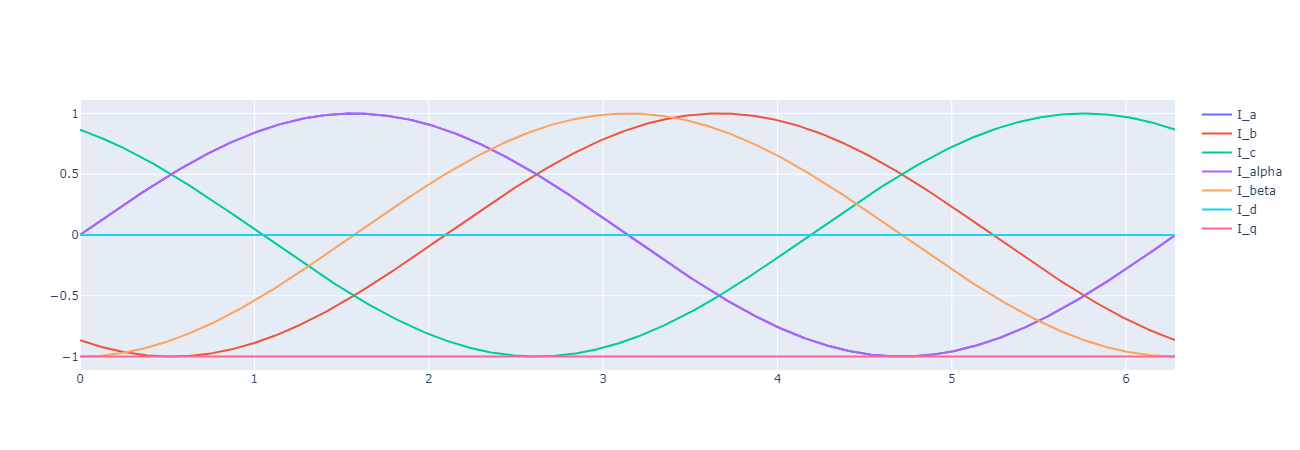

In [55]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=t,
    y=iabc[0],
    name="I_a"
))

fig.add_trace(go.Scatter(
    x=t,
    y=iabc[1],
    name="I_b"
))

fig.add_trace(go.Scatter(
    x=t,
    y=iabc[2],
    name="I_c"
))
fig.add_trace(go.Scatter(
    x=t,
    y=iab[0],
    name="I_alpha"
))

fig.add_trace(go.Scatter(
    x=t,
    y=iab[1],
    name="I_beta"
))
fig.add_trace(go.Scatter(
    x=t,
    y=idq[0],
    name="I_d"
))

fig.add_trace(go.Scatter(
    x=t,
    y=idq[1],
    name="I_q"
))


fig.show()

## 3相電流->dq軸電流に一気に変換（相対）
$$
\begin{bmatrix}
    i_{d} \\
    i_{q}
\end{bmatrix}
    =
\frac{2}{3}
\begin{bmatrix}
     \cos\theta &  \cos(\theta - \frac{2}{3}\pi) &  \cos(\theta + \frac{2}{3}\pi)  \\
    -\sin\theta & -\sin(\theta - \frac{2}{3}\pi) & -\sin(\theta + \frac{2}{3}\pi)  \\
    \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}}  \\
\end{bmatrix}
\begin{bmatrix}
    i_a \\
    i_b \\
    i_c
\end{bmatrix}
$$

In [56]:
# 一気に変換

invsqrt2 = np.empty(len(t))
invsqrt2[:] = 1/(np.sqrt(2))

park = 2/3 * np.array([
    [ np.cos(Omega * t),  np.cos(Omega * t - 2*np.pi/3),  np.cos(Omega * t + 2*np.pi/3)],
    [-np.sin(Omega * t), -np.sin(Omega * t - 2*np.pi/3), -np.sin(Omega * t + 2*np.pi/3)],
    [          invsqrt2,                       invsqrt2,                       invsqrt2]
])
iabc_temp = iabc.T
idq2 = np.empty([3, len(t)])
for i in range(len(t)):
    idq2[:,i] = np.dot(park[:,:,i], iabc_temp[i,:])

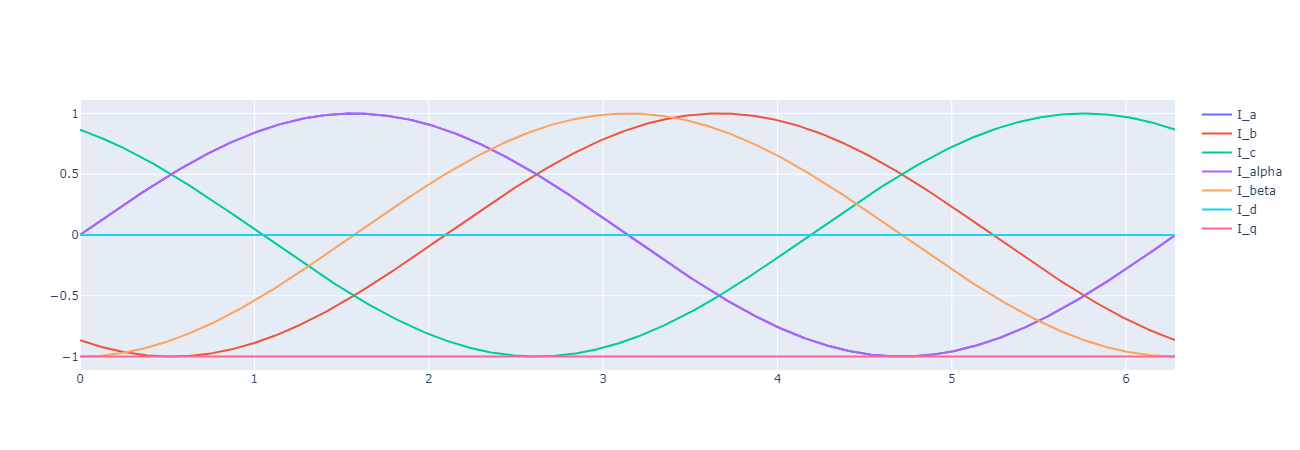

In [57]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=t,
    y=iabc[0],
    name="I_a"
))

fig.add_trace(go.Scatter(
    x=t,
    y=iabc[1],
    name="I_b"
))

fig.add_trace(go.Scatter(
    x=t,
    y=iabc[2],
    name="I_c"
))
fig.add_trace(go.Scatter(
    x=t,
    y=iab[0],
    name="I_alpha"
))

fig.add_trace(go.Scatter(
    x=t,
    y=iab[1],
    name="I_beta"
))
fig.add_trace(go.Scatter(
    x=t,
    y=idq2[0],
    name="I_d"
))

fig.add_trace(go.Scatter(
    x=t,
    y=idq2[1],
    name="I_q"
))


fig.show()

## メモ

定義に沿ってに変換したらQ軸が負の値になった．  
教科書で見るような波形はQ軸が正の値に書かれてることが多くイメージと反する．->3相の電流と位相角度に注意する．  
3相電流を反時計回りにa,b,cと定義．  
2相電流のαをaと同じ角度に一致．
αから反時計回り90°にβと定義，
dから反時計周り90°にqと定義，
αからの角度をθとしてdを定義すると，θを増やすときのq軸電流の方向は負になる．